## Prepare dataset: Video pack into numpy array

In [62]:
import numpy as np
import cv2 as cv
from keras import layers , models , optimizers
from sklearn.model_selection import train_test_split
import os

import matplotlib.pyplot as plt

### Section $I$ : Extract Lanes

Section $I$ sources:

In [63]:
def get_bright_pixels(img : np.ndarray) -> np.ndarray:
    """
    Finds the location of bright pixels in an image.
    Args:
        img: a NumPy array of shape (height, width, 3) storing an image
    Returns:
        A boolean NumPy array of shape (height, width) where True indicates the location of bright pixels.
    """
    pixel_mask = (img > 175)
    bright_pixels = np.all(pixel_mask , axis=2)

    return bright_pixels

def get_lane_beginnings(mask : np.ndarray) -> tuple[int , int]:
    """
    Estimates the x-coordinates of the lane beginnings.
    Args:
        mask: a boolean NumPy array of shape (height, width) where True indicates the location of bright pixels.
    Returns:
        A tuple of two integers, containing the estimated x-coordinate of the beginning of the left and right lane respectively.
    """
    bottom = mask[int(0.95 * mask.shape[0]): , :]
    bottom = bottom.sum(axis=0)
    threshold = bottom.max() / 3


    selected_X_cor = np.argwhere((bottom > threshold))
    spliiting_point = np.mean(selected_X_cor)
    # right is 1 , left is 0
    label = np.where(selected_X_cor < spliiting_point, 0, 1)
    left_median = int(np.median(selected_X_cor[label == 0]))
    right_median = int(np.median(selected_X_cor[label == 1]))

    return left_median , right_median

def get_whole_lanes(mask : np.ndarray, left_lane : int, right_lane : int) -> tuple[np.ndarray , np.ndarray]:
    """
    Uses the beginning of the lanes to refine the mask so that those unrelated bright pixels are filtered out.
    Args:
        mask: a NumPy array of shape (height, width) where True indicates the bright pixels
        left_lane: the x-coordinate of the beginning of the left lane
        right_lane: the x-coordinate of the beginning of the right lane
    Returns:
        A tuple of 2 boolean NumPy arrays, each array with shape (height, width), corresponding to the left lane and right lane.
    """
    depth = mask.shape[0]
    n_bounding_boxes = 9
    # TODO: left lane
    left_img = np.zeros_like(mask)
    y = depth
    x = left_lane
    for _ in range(n_bounding_boxes):
        row_slice = np.copy(mask[y - 72 : y])
        left_bound = max(0 , x - 110)
        right_bound = min(mask.shape[1] , x + 110)

        row_slice[: , : left_bound] = 0
        row_slice[: , right_bound :] = 0

        if not row_slice.any():
            break

        left_img[y - 72 : y, :] |= row_slice
        y -= 72
        x = int(np.mean(np.argwhere(row_slice) , axis=0)[1])
    
    # TODO: right lane
    right_img = np.zeros_like(mask)
    y = depth
    x = right_lane
    for _ in range(n_bounding_boxes):
        row_slice = np.copy(mask[y-72 : y])
        left_bound = max(0, x - 110)
        right_bound = min(mask.shape[1], x + 110)

        row_slice[:, : left_bound] = 0
        row_slice[:, right_bound :] = 0
        
        if not row_slice.any():
            break
        
        right_img[y - 72 : y , :] |= row_slice
        y -= 72
        x = int(np.mean(np.argwhere(row_slice), axis=0)[1])

    return left_img , right_img

def get_lane_edges(left_lane, right_lane):
    """
    Extracts lane edges.
    Args:
        left_lane: a boolean NumPy array of shape (height, width) where True indicates the pixels for the left lane
        right_lane: a boolean NumPy array of shape (height, width) where True indicates the pixels for the right lane
    Returns:
        A tuple of 2 boolean NumPy arrays each with shape (height, width), containing the edges of the left lane and the right lane respectively
    """
    # define the kernels
    edge_left_kernel = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])      # use this for left edge detection
    edge_right_kernel = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])     # use this for right edge detection
    structuring_element = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8) # use this for erosion and closing

    def process_lane(lane_mask: np.ndarray):
        lane = lane_mask.astype(np.uint8) * 255
        lane = cv.erode(lane , structuring_element , iterations=3)
        lane = cv.morphologyEx(lane , cv.MORPH_CLOSE , structuring_element , iterations=10)

        edge_l = cv.filter2D(lane , -1 , edge_left_kernel)
        edge_r = cv.filter2D(lane , -1 , edge_right_kernel)

        return (edge_l | edge_r).astype(bool)       

    l_edge = process_lane(left_lane)
    r_edge = process_lane(right_lane)    

    return l_edge , r_edge

Section $I$ Main:

In [64]:
def extract_lane_edges(img):
    """
    The main function of section 1.  Extracts the lane edges from an image.
    Args:
        img: a NumPy array of shape (height, width, 3) storing an image
    Returns:
        A tuple of 2 boolean NumPy arrays each with shape (height, width), containing the edges of the left lane and the right lane respectively
    """
    mask = get_bright_pixels(img)
    lm , rm = get_lane_beginnings(mask)
    left_lane , right_lane = get_whole_lanes(mask , lm , rm)
    left_edge , right_edge = get_lane_edges(left_lane , right_lane)

    return left_edge , right_edge

#### Potential Issues in Section I (Lane Extraction):
1.  **`get_bright_pixels`**: The fixed threshold `175` might not be robust across different lighting conditions or video frames. Adaptive thresholding could be more effective.
2.  **`get_lane_beginnings`**: 
    *   Relying on the bottom 5% (`0.95 * mask.shape[0]`) might be too small or too large depending on the camera angle and road perspective.
    *   The threshold `bottom.max() / 3` is arbitrary and might fail if the lane markings are faint or if there are other bright objects near the bottom.
    *   Using the mean to split left/right points and then the median might be sensitive to outliers or skewed distributions of bright pixels.
3.  **`get_whole_lanes`**: 
    *   The fixed window height (`72`) and width (`110` on each side) might not adapt well to lanes that curve sharply or change width significantly.
    *   Updating the center `x` based on the mean of detected pixels in the window can drift off if the window includes noise or only a small part of the lane.
    *   The loop breaks if `row_slice.any()` is false. This might stop the lane detection prematurely if there's a small gap in the lane marking.
4.  **`get_lane_edges`**: 
    *   The number of iterations for erosion (`3`) and closing (`10`) are fixed and might over-erode or over-close depending on the input lane thickness and continuity.
    *   Using simple edge kernels (`edge_left_kernel`, `edge_right_kernel`) after significant morphological operations might not accurately capture the original lane edge if the shapes were heavily distorted.

### Section $II$ : Estimate Road Curvature & turn direction

Section $II$ sources:

In [65]:
def get_quadratic_fit(left_lane_edge : np.ndarray, right_lane_edge : np.ndarray) -> np.polynomial.polynomial.Polynomial:
    """
    Fits a quadratic to the left lane and right lane using the edges of the lane markings.
    Args:
        left_lane-edge: a boolean NumPy array of shape (height, width) where True indicates the pixels for the left lane edges
        right_lane_edge: a boolean NumPy array of shape (height, width) where True indicates the pixels for the right lane edges
    Returns:
        a tuple containing two quadratics.
        return_val[0] is the fitted left quadratic, and return_val[2] is the fitted right quadratic
    """
    # TODO: Left lane
    cordL = np.argwhere(left_lane_edge)
    left_xcor = cordL[: , 0]
    left_ycor = cordL[: , 1]

    cordR = np.argwhere(right_lane_edge)
    right_xcor = cordR[: , 0]
    right_ycor = cordR[: , 1]

    # Hint: use NumPy slicing and indexing to pass the correct coordinates of edges to fit the polynomial
    left_poly = np.polynomial.polynomial.Polynomial.fit(x=left_xcor, y=left_ycor, deg=2)
    right_poly = np.polynomial.polynomial.Polynomial.fit(x=right_xcor, y=right_ycor, deg=2)

    return left_poly, right_poly

def get_middle_quadratic(left_poly, right_poly):
    """ Returns the average of the left and right polynomial """
    # average left and right quadratic, and handle NumPy domain issues
    middle_poly = (left_poly.convert(domain=[0, 1439]) + right_poly.convert(domain=[0, 1439])) / 2
    a, b, c, d = left_poly.domain[0], right_poly.domain[0], left_poly.domain[1], right_poly.domain[1]
    middle_poly = middle_poly.convert(domain=[min(a, b, c, d), max(a, b, c, d)])
    return middle_poly

def get_curvature_and_direction(poly):
    """
    Estimates the curvature and turn direction from the averaged (middle) polynomial
    Args:
        poly: the middle polynomial
    Returns:
        A tuple containing the curvature and the strings "left" or "right"
    """
    # evalute the curvature and turn direction at this point
    pt = poly.domain.mean()

    # k(poly)(x) computes the curvature of a polynomial 'poly' at the point 'x', using the formula curvature = |p''| / (1+(p')^2)^1.5
    k = lambda poly: lambda x: np.abs(poly.deriv(m=2)(x)) / ((1 + poly.deriv(m=1)(x) ** 2) ** 1.5)

    # positive second derivative => turn right, negative second derivative => turn left
    twice_deriv = poly.deriv(m=2)(pt)
    direction = "right" if twice_deriv > 0 else "left"

    return k(poly)(pt), direction

def get_direction_vector(curv, direction):
    """ Finds the direction vector to move in """
    r = 1 / curv # find radius of tangent circle
    s = 350 # move 350 pixels along the tangent circle
    if (direction == "left"):
        dx = - r + r * np.cos(s/r)
        dy = - r * np.sin(s/r)
    elif (direction == "right"):
        dx = + r - r * np.cos(s/r)
        dy = - r * np.sin(s/r)
    return dx, dy

Section $II$ Main:

In [66]:
def extract_direction_vector(img):
    """
    Finds how much to move in the x and y direction.
    Args:
        img: a NumPy array of shape (height, width, 3) storing an image
    Returns:
        a tuple containing 2 floating point numbers.  The first one is dx, the second one is dy.
    """
    ### TODO: Your code goes here! ###
    left_edge , right_edge = extract_lane_edges(img)
    left_poly , right_poly = get_quadratic_fit(left_edge , right_edge)
    middle_poly = get_middle_quadratic(left_poly , right_poly)
    curvy , direction = get_curvature_and_direction(middle_poly)
    dx , dy = get_direction_vector(curvy , direction) 
    
    return dx , dy

#### Potential Issues in Section II (Curvature & Direction):
1.  **`get_quadratic_fit`**: 
    *   Fitting a quadratic assumes the lane is roughly parabolic in the image perspective. This might be inaccurate for very straight sections or complex curves (like S-bends).
    *   The `Polynomial.fit` function can be sensitive to the distribution and number of points. Outliers or sparse data points from `get_lane_edges` can significantly skew the fit.
    *   The coordinates are used directly (pixels). Converting to real-world coordinates (e.g., meters) using camera calibration and inverse perspective mapping would provide a more meaningful curvature.
2.  **`get_middle_quadratic`**: 
    *   Simple averaging of polynomial coefficients assumes the left and right lanes are parallel and equidistant in the image space after perspective distortion, which might not hold true, especially on curves.
    *   Handling the `domain` explicitly might be necessary, but averaging polynomials defined on potentially different domains (due to fitting different sets of points) needs careful consideration.
3.  **`get_curvature_and_direction`**: 
    *   Calculating curvature from a polynomial fitted to image coordinates doesn't give the actual road curvature in meters. The result is in pixels⁻¹.
    *   Evaluating curvature at the `poly.domain.mean()` (middle y-value of the detected lane points) might not be the most relevant point (e.g., the point closest to the vehicle might be more important).
    *   The sign of the second derivative determining left/right depends on the coordinate system (how x and y are defined relative to the image and the direction of travel).
4.  **`get_direction_vector`**: 
    *   Calculating `dx, dy` based on the radius of curvature `r = 1 / curv` assumes the car follows a circular path, derived from the polynomial fit at a single point.
    *   The fixed distance `s = 350` pixels to move along the tangent circle is arbitrary and doesn't relate directly to vehicle speed or control dynamics.
    *   The formulas for `dx` and `dy` seem to calculate the displacement along a circular arc, but their correctness depends heavily on the coordinate system and the definition of curvature.

### Visulizations: 

In [67]:
def show_polynomials_and_vector(img):
    """
    Plots polynomials and the direction vector onto the image.
    """
    h, _, _ = img.shape

    left_poly, right_poly = get_quadratic_fit(*extract_lane_edges(img))
    middle_poly = get_middle_quadratic(left_poly, right_poly)

    dx, dy = extract_direction_vector(img)
    direction = "left" if dx < 0 else "right"

    # get the points to evaluate the curvature at
    pt = middle_poly.domain.mean()

    # get the xy coordinates of the polynomial at various points
    left_y, left_x = left_poly.linspace(n=50)
    middle_y, middle_x = middle_poly.linspace(n=50)
    right_y, right_x = right_poly.linspace(n=50)

    # load image into matplotlib
    plt.imshow(img)

    # plot polynomial points on top of the image
    plt.scatter(x=left_x, y=left_y, color='green', s=7) # plot left poly
    plt.scatter(x=middle_x, y=middle_y, color='yellow', s=7) # plot middle poly
    plt.scatter(x=right_x, y=right_y, color='blue', s=7) # plot right poly
    plt.scatter(x=[middle_poly(pt)], y=[pt], color='purple') # plot point to evaluate curvature at
    plt.arrow(x=middle_poly(pt), y=pt, dx=dx, dy=dy, width=20, color=(1, 0, 0)) # draw direction vector
    plt.text(x=20, y=h-20, s=f"{direction} by {np.abs(dx)} px", fontsize='xx-large', color='white')

    plt.show()

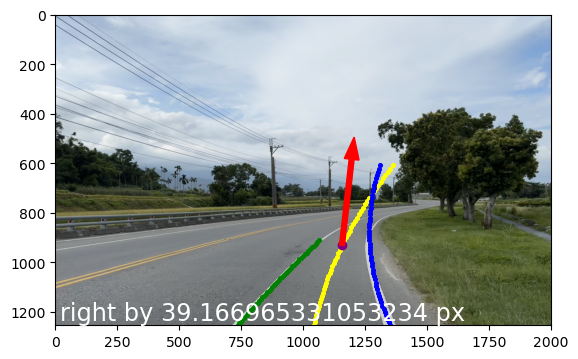

In [68]:
img = cv.imread("./pa2_dataset/img6.png")
img = cv.cvtColor(img , cv.COLOR_BGR2RGB)
show_polynomials_and_vector(img)

### Section $III$ : Video to Numpy

In [69]:
def video_to_np(filename):
    """
    Pass in the filename (a string), returns a tuple containing the frames and the dx values for those frames
    Usage example: x, y = video_to_np("drive/MyDrive/video1.MOV")
    """
    cap = cv.VideoCapture(filename)
    counter = 0
    x = [] # stores the frames
    y = [] # stores the dx's
    while (cap.isOpened()):
        ret, frame = cap.read() # 'ret' is a boolean, where True signifies the frame is read successfully. 'frame' is a NumPy array of the image.
        # break if reached end of video
        if (not ret):
            break
        # only consider every 30th frame
        if (counter % 30 == 0):
        # try to extract dx (it may not work if the video contains frames with unclear or non-existing road markings, don't worry about this)
            try:
                dx, _ = extract_direction_vector(cv.cvtColor(frame, cv.COLOR_BGR2RGB))
                y.append(dx)
            except Exception as e:
                print(f"Error in frame {counter}:", e)
                y.append(y[-1] if len(y) > 0 else 0)
            frame = cv.resize(frame, (320, 240)) # reduce resolution of image.  cv.resize uses (width, height)
            frame = np.expand_dims(cv.cvtColor(frame, cv.COLOR_RGB2GRAY), axis=2)  # change to grayscale and reshape to (height, width, 1)
            frame[:120] = 0 # change the upper half of the image to black
            x.append(frame)
            # increment frame number counter
        counter += 1

    return x, y

In [70]:
def format_dataset(filenames):
    """
    Packs every 5 seconds of footage together, and also the mapped dx value corresponding to the last frame.
    Args:
        filenames: a list of strings.  For example ["drive/MyDrive/video1.MOV", "drive/MyDrive/video2.MOV"]
        video_to_np: this parameter exists so that we can test your code without your mistakes carrying over
    Returns:
        A tuple containing 2 NumPy arrays, the first one storing the frames and the second one storing the mapped dx values
    """

    Xs = np.zeros(shape=(0 , 5 , 240 , 320 , 1)) 
    ys = np.zeros(shape=(0,)) 

    for filename in filenames:
        print(f"processing {filename}")

        x , dxs = video_to_np(filename)
        x = np.array(x)
        dxs = np.array(dxs)

        # pack to a group of 5
        X = np.zeros(shape=(x.shape[0] - 4 , 5 , 240 , 320 , 1))
        length = x.shape[0]
        for i in range(length):
            if (i + 5) > length:
                break
            part = x[i : i + 5]
            X[i] = part

        # directly concatenate to xs
        Xs = np.vstack((Xs , X))
        # find labels
        labels = dxs[4:]
        # append to ys
        ys = np.hstack((ys , labels))

    # change label into 0 , 1 ,2
    #zeros_mask = (ys < -10)
    #ones_mask = (ys >= -10) & (ys <= 10)
    #twos_mask = (ys > 10)

    #ys[zeros_mask] = 0
    #ys[ones_mask] = 1
    #ys[twos_mask] = 2

    return Xs , ys

### Section $IV$ : Change the video samples to Numpy Array

In [71]:
data_set_dir = "./pa2_dataset/"

filenames = [
    os.path.join(data_set_dir , "video1.MOV"),
    os.path.join(data_set_dir , "video2.MOV"),
    os.path.join(data_set_dir , "video3.MOV"),
    os.path.join(data_set_dir , "video4.MOV"),
    os.path.join(data_set_dir , "video6.MOV"),
    os.path.join(data_set_dir , "video7.MOV"),
]

# Ensure video_to_np and format_dataset are defined before this cell is run
Xs , ys = format_dataset(filenames)

np.save("x.npy" , Xs)
np.save("y.npy" , ys)

print(Xs.shape , ys.shape)

processing ./pa2_dataset/video1.MOV
processing ./pa2_dataset/video2.MOV
processing ./pa2_dataset/video2.MOV
processing ./pa2_dataset/video3.MOV
processing ./pa2_dataset/video3.MOV
processing ./pa2_dataset/video4.MOV
processing ./pa2_dataset/video4.MOV
Error in frame 930: Coefficient array is empty
Error in frame 960: Coefficient array is empty
Error in frame 930: Coefficient array is empty
Error in frame 960: Coefficient array is empty
Error in frame 990: Coefficient array is empty
Error in frame 1020: Coefficient array is empty
Error in frame 990: Coefficient array is empty
Error in frame 1020: Coefficient array is empty
Error in frame 1410: Coefficient array is empty
Error in frame 1440: Coefficient array is empty
Error in frame 1410: Coefficient array is empty
Error in frame 1440: Coefficient array is empty
processing ./pa2_dataset/video6.MOV
Error in frame 0: Coefficient array is empty
processing ./pa2_dataset/video6.MOV
Error in frame 0: Coefficient array is empty


e:\Conda\envs\Butterfly\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
e:\Conda\envs\Butterfly\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error in frame 30: cannot convert float NaN to integer
Error in frame 60: Coefficient array is empty
Error in frame 60: Coefficient array is empty
Error in frame 120: cannot convert float NaN to integer
Error in frame 120: cannot convert float NaN to integer
Error in frame 150: Coefficient array is empty
Error in frame 150: Coefficient array is empty
Error in frame 300: Coefficient array is empty
Error in frame 300: Coefficient array is empty
Error in frame 900: Coefficient array is empty
Error in frame 900: Coefficient array is empty
processing ./pa2_dataset/video7.MOV
processing ./pa2_dataset/video7.MOV
(208, 5, 240, 320, 1) (208,)
(208, 5, 240, 320, 1) (208,)
